In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
import gpustat
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch import nn
from torchvision.io import read_image
import torchvision.transforms as transforms

import sklearn
import sklearn.model_selection

rng = np.random.default_rng()

In [2]:
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)
print(stats)

GPUStatCollection(host=poppy, [
  [0] NVIDIA A100 80GB PCIe | 60°C,  90 % | 80236 / 81920 MB | chriscs(80234M)
  [1] NVIDIA A100 80GB PCIe | 57°C,  98 % | 80236 / 81920 MB | chriscs(80234M)
  [2] NVIDIA A100 80GB PCIe | 28°C,   0 % |     2 / 81920 MB |
])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
base_folder = "spatial_sim_data"
labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N", "n", "nPO"])
print(labels)

                                        path      N    n  nPO
0      images/spatial_sim_parents_1000_0_500   1011  500  127
1      images/spatial_sim_parents_1000_1_500   1017  500  120
2      images/spatial_sim_parents_1000_2_500   1027  500  114
3      images/spatial_sim_parents_1000_3_500   1024  500  119
4      images/spatial_sim_parents_1000_4_500   1009  500  113
...                                      ...    ...  ...  ...
2515  images/spatial_sim_parents_9900_23_500   9958  500   10
2516  images/spatial_sim_parents_9900_24_500  10030  500   15
2517  images/spatial_sim_parents_9900_25_500   9958  500   12
2518  images/spatial_sim_parents_9900_26_500  10033  500    9
2519  images/spatial_sim_parents_9900_27_500  10041  500   11

[2520 rows x 4 columns]


In [5]:
idx = 0
base_path = base_folder + "/" + labels['path'].iloc[0]
spaghetti_path = base_path + "_spaghetti.png"
samples_path = base_path + "_samples.png"
print(spaghetti_path)
print(samples_path)
spaghetti = read_image(spaghetti_path)
samples = read_image(samples_path)

spatial_sim_data/images/spatial_sim_parents_1000_0_500_spaghetti.png
spatial_sim_data/images/spatial_sim_parents_1000_0_500_samples.png


In [6]:
print(spaghetti.size())
print(samples.size())
# Number of samples, should be 500
print(samples.sum()/255)
images = torch.cat((spaghetti, samples), 0)
print(images.size())

torch.Size([1, 500, 500])
torch.Size([1, 500, 500])
tensor(499.)
torch.Size([2, 500, 500])


In [7]:
class KinDataset(Dataset):
    def __init__(self, base_folder, labels_file):
        self.labels = pd.read_csv(base_folder + "/" + labels_file, names = ["path", "N", "n", "nPO"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        base_path = self.base_folder + "/" + self.labels['path'].iloc[idx]
        spaghetti_path = base_path + "_spaghetti.png"
        samples_path = base_path + "_samples.png"
        spaghetti = read_image(spaghetti_path)
        samples = read_image(samples_path)
        input_tensor = torch.cat((spaghetti, samples), 0).float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label
    
kin_dataset = KinDataset("spatial_sim_data", "labels.csv")

In [8]:
print(kin_dataset[2][0].size())
print(kin_dataset[2][1])
print(kin_dataset[100][1])

torch.Size([2, 500, 500])
tensor([1027.])
tensor([1319.])


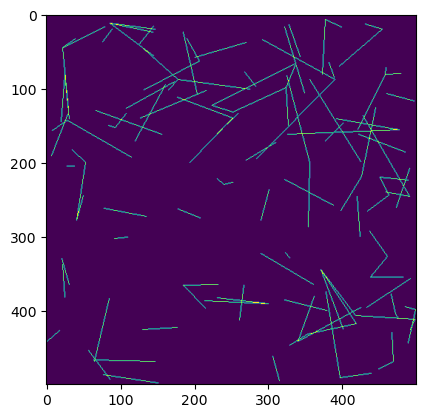

In [9]:
plt.imshow(kin_dataset[2][0][0])

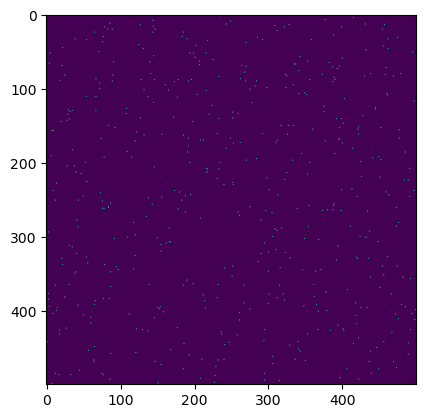

In [10]:
plt.imshow(kin_dataset[2][0][1])

In [11]:
n_total = len(kin_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [12]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

1260
630
630


In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(1000000, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten() 
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = Net()
model = model.to(device) 

In [82]:
# Exploring model
conv1 = nn.Conv2d(in_channels=2, out_channels=32, kernel_size=5, padding=2)
conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
fc1 = nn.Linear(1000000, 1024)
fc2 = nn.Linear(1024, 1)
dropout = nn.Dropout(p=0.2)
pool = nn.MaxPool2d(kernel_size=2)
relu = nn.ReLU()


In [87]:
# Input tensor
x = kin_dataset[2][0]
print("Input", x.size())
# first convolution
x = conv1(x)
print("Convolution 1", x.size())
# Relu, pool
x = pool(relu(x))
print("Relu, pool", x.size())
# Convolution 2
x = conv2(x)
print("Convolution 2", x.size())
# Relu, pool
x = pool(relu(x))
print("Relu, pool", x.size())
# Flatten
x = x.flatten()
print("Flatten", x.size())
# FC1
x = dropout(relu(fc1(x)))
print("FC1", x.size())
# FC2
x = fc2(x)
print("FC2", x.size())

Input torch.Size([2, 500, 500])
Convolution 1 torch.Size([32, 500, 500])
Relu, pool torch.Size([32, 250, 250])
Convolution 2 torch.Size([64, 250, 250])
Relu, pool torch.Size([64, 125, 125])
Flatten torch.Size([1000000])
FC1 torch.Size([1024])
FC2 torch.Size([1])


In [14]:
loss_fn = nn.MSELoss(reduction='mean')

In [15]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} loss: {loss_hist_train[epoch]:.4f} val_loss: {loss_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid

In [16]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_kin_dl, valid_kin_dl)

Epoch 1 loss: 16522954.1079 val_loss: 11571693.9937
Epoch 2 loss: 8155843.1889 val_loss: 7374568.4286
Epoch 3 loss: 3729859.5929 val_loss: 3045811.3778
Epoch 4 loss: 1418438.5369 val_loss: 1816804.9996
Epoch 5 loss: 791345.9726 val_loss: 1704275.9250
Epoch 6 loss: 517036.8592 val_loss: 1560447.8448
Epoch 7 loss: 350049.5586 val_loss: 1644320.2187
Epoch 8 loss: 260865.5441 val_loss: 1567553.8373
Epoch 9 loss: 176139.2400 val_loss: 1770712.3353
Epoch 10 loss: 125306.1155 val_loss: 1703939.8405
Epoch 11 loss: 76040.8028 val_loss: 1635407.2349
Epoch 12 loss: 58039.7441 val_loss: 1651431.7083
Epoch 13 loss: 51783.1223 val_loss: 1647737.8349
Epoch 14 loss: 43402.3488 val_loss: 1647504.2853
Epoch 15 loss: 34995.2944 val_loss: 1697199.0778
Epoch 16 loss: 37861.4711 val_loss: 1659371.7167
Epoch 17 loss: 38454.7251 val_loss: 1710752.3270
Epoch 18 loss: 37018.5646 val_loss: 1658334.6052
Epoch 19 loss: 39544.3803 val_loss: 1727847.8250
Epoch 20 loss: 32345.5938 val_loss: 1691568.3278


In [27]:
#Save model
PATH = "spaghetti_nn_results/first_model.pt"
torch.save(model.state_dict(), PATH)

In [16]:
# Load model
PATH = "spaghetti_nn_results/first_model.pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

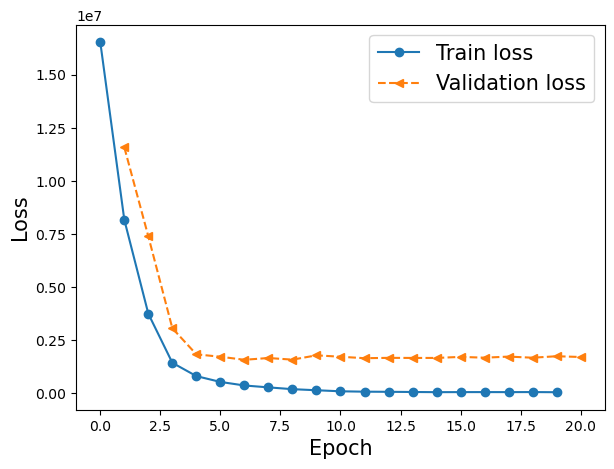

In [22]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [23]:
torch.cuda.synchronize()
model_cpu = model.cpu()

test_truth = np.empty(len(test_kin))
test_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        test_pred[i] = model(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
        #test_pred[i] = test_output.numpy()
        #test_truth[i] = test_output[0].numpy()
        #test_pred[i] = model(test_input)[0, 0].numpy()

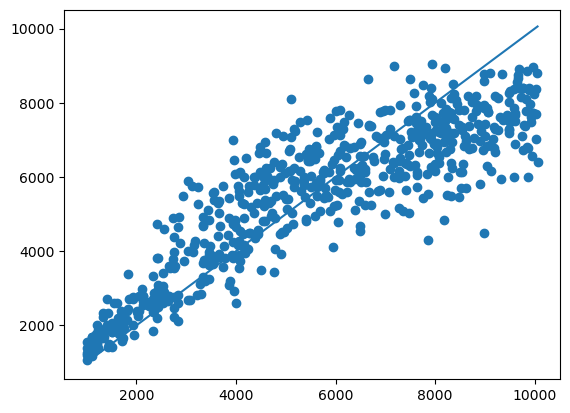

In [31]:
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

In [35]:
# Write test results to file
results = {'truth': test_truth, 'unbiased_nn_pred': test_pred}
df = pd.DataFrame(data=results)
df.to_csv("spaghetti_nn_results/unbiased_nn_results.csv", index = False)

# Network trained on spatially biased sampling

1260
630
630


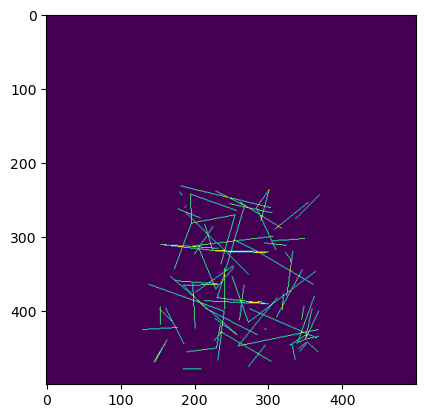

In [26]:
# Train on spatially biased sampling
bias_dataset = KinDataset("spatial_sim_data", "labels_bias.csv")
plt.imshow(bias_dataset[2][0][0])
n_total = len(bias_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid
train_bias, valid_bias, test_bias = random_split(bias_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))
batch_size = 64
train_bias_dl = DataLoader(train_bias, batch_size, shuffle = True)
valid_bias_dl = DataLoader(valid_bias, batch_size, shuffle = True)
test_bias_dl = DataLoader(test_bias, batch_size, shuffle = True)
print(len(train_bias))
print(len(valid_bias))
print(len(test_bias))

In [27]:
model_bias = Net()
model_bias = model_bias.to(device) 

In [28]:
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_bias.parameters(), lr=0.0001)
torch.manual_seed(1)
num_epochs = 20
hist = train(model_bias, num_epochs, train_bias_dl, valid_bias_dl)

Epoch 1 loss: 15630376.8032 val_loss: 10427171.0444
Epoch 2 loss: 7551716.2429 val_loss: 6609421.2365
Epoch 3 loss: 3613086.7274 val_loss: 2625587.5659
Epoch 4 loss: 1131855.4571 val_loss: 1202250.2385
Epoch 5 loss: 684161.3315 val_loss: 995394.9935
Epoch 6 loss: 489532.8357 val_loss: 959688.8587
Epoch 7 loss: 396651.6239 val_loss: 895305.3982
Epoch 8 loss: 338096.5397 val_loss: 883529.7972
Epoch 9 loss: 252164.1231 val_loss: 886153.0228
Epoch 10 loss: 215951.9353 val_loss: 995695.6369
Epoch 11 loss: 181840.3516 val_loss: 886697.2740
Epoch 12 loss: 149198.9269 val_loss: 916325.7813
Epoch 13 loss: 122614.5030 val_loss: 867031.2159
Epoch 14 loss: 103116.4215 val_loss: 914104.3673
Epoch 15 loss: 88934.7530 val_loss: 898074.2933
Epoch 16 loss: 87007.1392 val_loss: 896431.5264
Epoch 17 loss: 78282.6168 val_loss: 910226.3786
Epoch 18 loss: 68165.9620 val_loss: 905179.2181
Epoch 19 loss: 60889.2655 val_loss: 932454.5290
Epoch 20 loss: 62353.6647 val_loss: 956478.1782


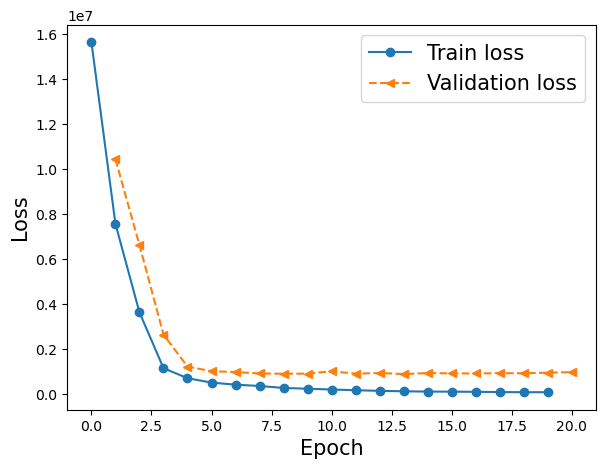

In [30]:
train_x = np.arange(len(hist[0]))
val_x = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_x, hist[0], '-o', label='Train loss')
ax.plot(val_x, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [30]:
#Save model
PATH = "spaghetti_nn_results/bias_model.pt"
torch.save(model_bias.state_dict(), PATH)

In [23]:
# Load model
PATH = "spaghetti_nn_results/bias_model.pt"
model_bias = Net()
model_bias.load_state_dict(torch.load(PATH))
model_bias.eval()

Net(
  (conv1): Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1000000, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

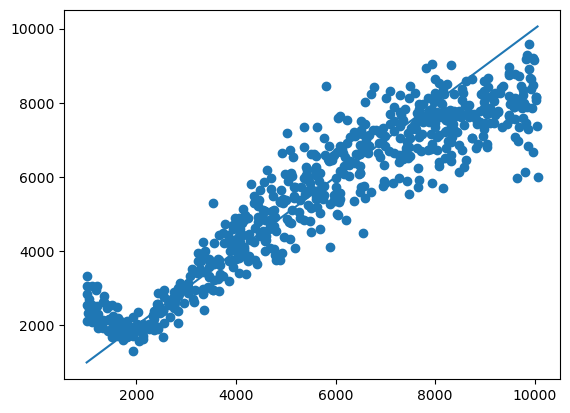

In [36]:
torch.cuda.synchronize()
model_cpu = model_bias.cpu()

test_truth = np.empty(len(test_bias))
test_pred = np.empty(len(test_bias))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_bias):
        test_pred[i] = model_bias(test_input.unsqueeze(0))[0][0]
        test_truth[i] = test_output[0]
plt.scatter(test_truth, test_pred)
plt.plot([np.min(test_truth), np.max(test_truth)], [np.min(test_truth), np.max(test_truth)])

It probably has the weird pattern under 2000 because the sample size is smaller for those populations.

In [37]:
# Write test results to file
results = {'bias_truth': test_truth, 'biased_nn_pred': test_pred}
df = pd.DataFrame(data=results)
df.to_csv("spaghetti_nn_results/biased_nn_results.csv", index = False)

## Does the model trained on random sampling work on spatially biased? Does it underestimate by a factor of 4 as expected?

In [38]:
# Test model trained on random sampling on biased sampling data set
torch.cuda.synchronize()

bias_truth = np.empty(len(test_bias))
rand_bias_pred = np.empty(len(test_bias))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_bias):
        rand_bias_pred[i] = model(test_input.unsqueeze(0))[0][0]
        bias_truth[i] = test_output[0]


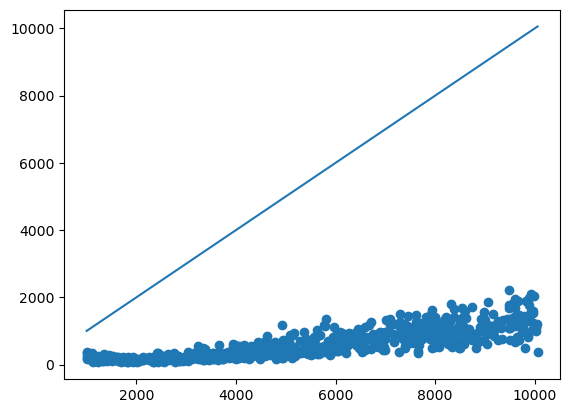

In [39]:
plt.scatter(bias_truth, rand_bias_pred)
plt.plot([np.min(bias_truth), np.max(bias_truth)], [np.min(bias_truth), np.max(bias_truth)])

In [41]:
# Write test results to file
results = {'bias_truth': bias_truth, 'unbiased_nn_pred': rand_bias_pred}
df = pd.DataFrame(data=results)
df.to_csv("spaghetti_nn_results/unbiased_nn_biased_data.csv", index = False)

In [42]:
# Test model trained on biased sampling on random sampling data set
torch.cuda.synchronize()

rand_truth = np.empty(len(test_kin))
bias_rand_pred = np.empty(len(test_kin))

with torch.no_grad():
    for i, (test_input, test_output) in enumerate(test_kin):
        bias_rand_pred[i] = model_bias(test_input.unsqueeze(0))[0][0]
        rand_truth[i] = test_output[0]

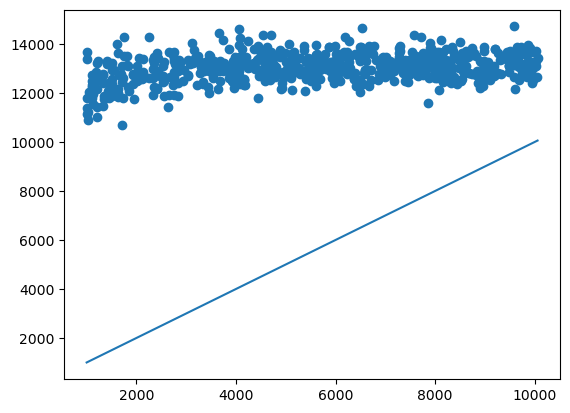

In [45]:
plt.scatter(rand_truth, bias_rand_pred)
plt.plot([np.min(rand_truth), np.max(rand_truth)], [np.min(rand_truth), np.max(rand_truth)])

The network doesn't seem to be using sample locations. How could I get it to learn to adjust for sampling intensity?
- Maybe training on different sampling plans would work?
- Input sampling intensity as an image
- Not worry about it

In [48]:
# Write test results to file
results = {'truth': rand_truth, 'biased_nn_pred': bias_rand_pred}
df = pd.DataFrame(data=results)
df.to_csv("spaghetti_nn_results/bias_nn_unbiased_data.csv", index = False)

In [33]:
# Train on just the spaghetti plots and see if it does just as well (it should)
class KinOnlyDataset(Dataset):
    def __init__(self, base_folder):
        self.labels = pd.read_csv(base_folder + "/labels.csv", names = ["path", "N", "n", "nPO"])
        self.base_folder = base_folder
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        base_path = self.base_folder + "/" + self.labels['path'].iloc[idx]
        spaghetti_path = base_path + "_spaghetti.png"
        spaghetti = read_image(spaghetti_path)
        input_tensor = spaghetti.float()
        label = torch.tensor([self.labels['N'].iloc[idx]]).float()
        return input_tensor, label
    
kin_only_dataset = KinOnlyDataset("spatial_sim_data")

In [ ]:
n_total = len(kin_only_dataset)
n_train = round(n_total*0.5)
n_valid = round((n_total-n_train)*0.5)
n_test = n_total-n_train-n_valid

In [ ]:
train_kin, valid_kin, test_kin = random_split(kin_dataset, [n_train, n_valid, n_test], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_kin_dl = DataLoader(train_kin, batch_size, shuffle = True)
valid_kin_dl = DataLoader(valid_kin, batch_size, shuffle = True)
test_kin_dl = DataLoader(test_kin, batch_size, shuffle = True)
print(len(train_kin))
print(len(valid_kin))
print(len(test_kin))

1260
630
630


tensor([[1.8642]], grad_fn=<AddmmBackward0>)
tensor([5373.])


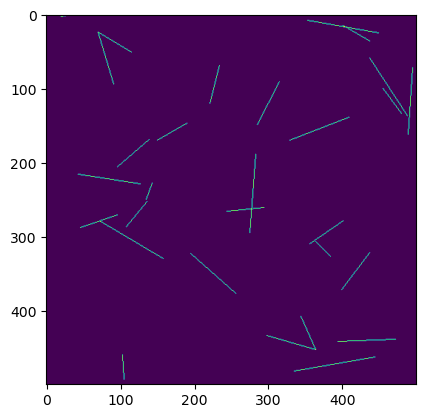

In [46]:
i = 1000
print(net(train_kin[i][0].unsqueeze(0)))
print(train_kin[i][1])
plt.imshow(train_kin[i][0][0])

In [ ]:
model_cpu = model.cpu()
i = 0
with(torch.no_grad()):
    pred = model_cpu(train_kin[i][0].unsqueeze(0))
truth = train_kin[i][1]
print(pred)
print(truth)
print(loss_fn(pred[0], truth))

tensor([[0.1483]])
tensor([3035.])
tensor(9210325.)


In [ ]:
x_batch, y_batch = next(iter(train_kin_dl))

In [ ]:
print(x_batch[0])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
